In [5]:
import torch.func as func
import matplotlib.pyplot as plt
import torch

Consider the residual function $f(x(p)) = Ax(p)-b$, where $x(p)$ is the solution to a matrix equation $A(p)x=b$, and $A$ depends on parameters $p$.
The method of conjugate gradient will be used to compute $x$, and will only be taken out to at most 15 iterations - there will be error in the solution, so $f$ will be non-zero.

I am concerned with computing $\nabla_p f$. Some of the observations I made that might help us make progess on super resolution are the following:

1. jacfwd will produce identical jacobians with or without diff through CG (I dont understand why). But jacrev will produce jacobians as we expect. This is shown below. I can confirm that there is a slight difference between the jacobians computed with forw and rev for super resolution, although its only a slight difference.

2. For this specific function, differentiating with jacrev through all iterations of CG is necessary to get a faster rate of error decrease in the convergence plots.

In [6]:
# spd diagonal matrix dependent on two parameters
def A(theta, C):
    return theta[0] * torch.eye(C.size(0), dtype=torch.float64) + theta[1] * C

def conjugate_gradient(A_func, b, theta, x0, max_iter=5, tol=1e-10):
    x = x0
    r = b - A_func(theta).matmul(x)
    p = r.clone()
    rsold = r.dot(r)
    for i in range(max_iter):
        Ap = A_func(theta).matmul(p)
        alpha = rsold / p.dot(Ap)
        x = x + alpha * p  
        r = r - alpha * Ap  
        rsnew = r.dot(r)
        if torch.sqrt(rsnew) < tol:
            # print(f"stopping at {i}")
            break
        p = r + (rsnew / rsold) * p
        rsold = rsnew
    # print("max iter reached")
    return x

def conjugate_gradient_nograd(A_func, b, theta, x0, max_iter=5, tol=1e-10):
    with torch.no_grad():
        x = x0.clone()  
        r = b - A_func(theta).matmul(x)
        p = r.clone()
        rsold = r.dot(r)
        for i in range(max_iter):
            Ap = A_func(theta).matmul(p)
            alpha = rsold / p.dot(Ap)
            x = x + alpha * p 
            r = r - alpha * Ap  
            rsnew = r.dot(r)
            if torch.sqrt(rsnew) < tol:
                break
            p = r + (rsnew / rsold) * p
            rsold = rsnew
        return x

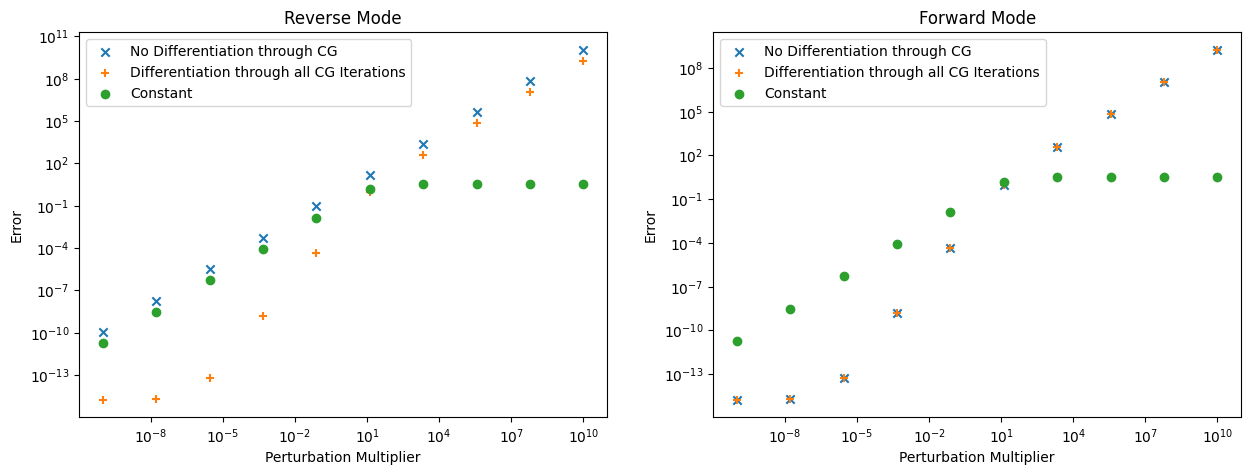

In [10]:
torch.manual_seed(0)

n = 50 # matrix dim
theta = torch.tensor([10.0, 5.0], requires_grad=True, dtype=torch.float64) # 2 parameters
C = torch.diag(torch.arange(1, n + 1, dtype=torch.float64))
b = torch.randn(n, dtype=torch.float64)
x0 = torch.zeros(n, dtype=torch.float64)

def res(theta, C, b, x0):
    x = conjugate_gradient(lambda theta: A(theta, C), b, theta, x0)
    return (A(theta, C) @ x) - b
    # return torch.square(x)

def res_nograd(theta, C, b, x0):
    x = conjugate_gradient_nograd(lambda theta: A(theta, C), b, theta, x0)
    return (A(theta, C) @ x) - b
    # return torch.square(x)

def jacfn(theta, C, b, x0):
    return func.jacrev(res)(theta, C, b, x0).detach()

def jacfn_nograd(theta, C, b, x0):
    return func.jacrev(res_nograd)(theta, C, b, x0).detach()

def jacfn_fwd(theta, C, b, x0):
    return func.jacfwd(res)(theta, C, b, x0).detach()

def jacfn_nograd_fwd(theta, C, b, x0):
    return func.jacfwd(res_nograd)(theta, C, b, x0).detach()

H = torch.logspace(10,-10,10)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
no_diffs = []
diffs = []
const = []

v = jacfn(theta, C, b, x0).T @ res(theta, C, b, x0) # in the direction of the gradient
v /= torch.norm(v)

res_normal = res(theta, C, b, x0)
res_nodiff = res_nograd(theta, C, b, x0)
Jacv_nodiff = jacfn_nograd(theta, C, b, x0) @ v
Jacv = jacfn(theta, C, b, x0) @ v

for h in H:
    no_diffs.append(torch.norm(res_nograd(theta + h * v, C, b, x0) - res_nodiff - h * Jacv_nodiff).detach())
    diffs.append(torch.norm(res(theta + h * v, C, b, x0) - res_normal - h * Jacv).detach())
    const.append(torch.norm(res(theta + h * v, C, b, x0) - res_normal).detach())

plt.scatter(H, no_diffs, marker='x', label = 'No Differentiation through CG')
plt.scatter(H, diffs, marker='+', label = 'Differentiation through all CG Iterations')
plt.scatter(H, const, marker='o', label = 'Constant')

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.legend()

plt.xlabel("Perturbation Multiplier")
plt.ylabel("Error")

plt.title("Reverse Mode")

plt.subplot(1,2,2)
no_diffs = []
diffs = []
const = []

v = jacfn_fwd(theta, C, b, x0).T @ res(theta, C, b, x0) # in the direction of the gradient
v /= torch.norm(v)

res_normal = res(theta, C, b, x0)
res_nodiff = res_nograd(theta, C, b, x0)
Jacv_nodiff = jacfn_nograd_fwd(theta, C, b, x0) @ v
Jacv = jacfn_fwd(theta, C, b, x0) @ v

for h in H:
    no_diffs.append(torch.norm(res_nograd(theta + h * v, C, b, x0) - res_nodiff - h * Jacv_nodiff).detach())
    diffs.append(torch.norm(res(theta + h * v, C, b, x0) - res_normal - h * Jacv).detach())
    const.append(torch.norm(res(theta + h * v, C, b, x0) - res_normal).detach())

plt.scatter(H, no_diffs, marker='x', label = 'No Differentiation through CG')
plt.scatter(H, diffs, marker='+', label = 'Differentiation through all CG Iterations')
plt.scatter(H, const, marker='o', label = 'Constant')

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.legend()

plt.xlabel("Perturbation Multiplier")
plt.ylabel("Error")

plt.title("Forward Mode")

plt.show()

Reverse Mode produces convergence plots like we would expect as you can see.

Different number of tracked steps:

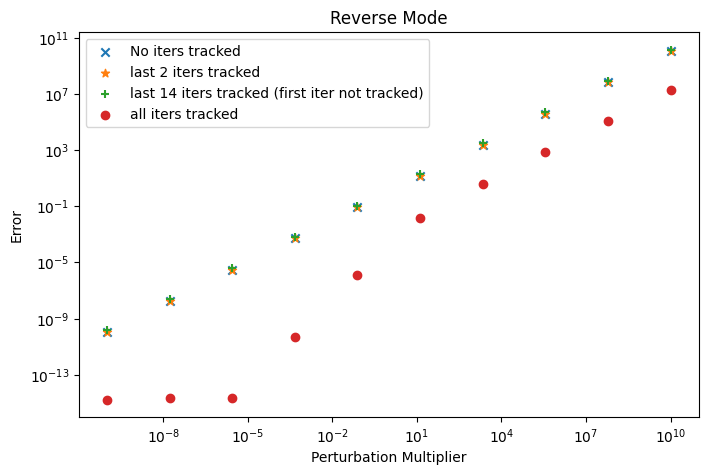

In [24]:
def conjugate_gradient(A_func, b, theta, x0, max_iter=15, tol=1e-10, grad_steps_tracked = 0):
    x = x0
    r = b - A_func(theta).matmul(x)
    p = r.clone()
    rsold = r.dot(r)

    with torch.no_grad():
        for i in range(max_iter - grad_steps_tracked):
            Ap = A_func(theta).matmul(p)
            alpha = rsold / p.dot(Ap)
            x = x + alpha * p  
            r = r - alpha * Ap  
            rsnew = r.dot(r)
            if torch.sqrt(rsnew) < tol:
                # print(f"stopping at {i}")
                break
            p = r + (rsnew / rsold) * p
            rsold = rsnew

    for i in range(grad_steps_tracked):
        Ap = A_func(theta).matmul(p)
        alpha = rsold / p.dot(Ap)
        x = x + alpha * p  
        r = r - alpha * Ap  
        rsnew = r.dot(r)
        if torch.sqrt(rsnew) < tol:
            # print(f"stopping at {i}")
            break
        p = r + (rsnew / rsold) * p
        rsold = rsnew
    # print("max iter reached")

    
    return x

torch.manual_seed(0)

n = 50 # matrix dim
theta = torch.tensor([10.0, 5.0], requires_grad=True, dtype=torch.float64) # 2 parameters
C = torch.diag(torch.arange(1, n + 1, dtype=torch.float64))
b = torch.randn(n, dtype=torch.float64)
x0 = torch.zeros(n, dtype=torch.float64)

def res(theta, C, b, x0, grad_step):
    x = conjugate_gradient(lambda theta: A(theta, C), b, theta, x0, grad_steps_tracked=grad_step)
    return (A(theta, C) @ x) - b
    # return torch.square(x)

def jacfn(theta, C, b, x0, grad_step):
    return func.jacrev(res)(theta, C, b, x0, grad_step).detach()


H = torch.logspace(10,-10,10)

plt.figure(figsize=(8,5))

diff_0 = []
diff_2 = []
diff_14 = []
diff_all = []

v = jacfn(theta, C, b, x0, 6).T @ res(theta, C, b, x0, 6) # in the direction of the gradient
v /= torch.norm(v)

res_0 = res(theta, C, b, x0, 0) #these are all the same since they only differ in iters tracked 
# res_2 = res(theta, C, b, x0, 2)
# res_14 = res(theta, C, b, x0, 14)
# res_all = res(theta, C, b, x0, 15)

Jacv_0 = jacfn(theta, C, b, x0, 0) @ v
Jacv_2 = jacfn(theta, C, b, x0, 2) @ v
Jacv_14 = jacfn(theta, C, b, x0, 14) @ v
Jacv_all = jacfn(theta, C, b, x0, 15) @ v

for h in H:
    diff_0.append(torch.norm(res(theta + h * v, C, b, x0, 0) - res_0 - h * Jacv_0).detach())
    diff_2.append(torch.norm(res(theta + h * v, C, b, x0, 2) - res_0 - h * Jacv_2).detach())
    diff_14.append(torch.norm(res(theta + h * v, C, b, x0, 14) - res_0 - h * Jacv_14).detach())
    diff_all.append(torch.norm(res(theta + h * v, C, b, x0, 15) - res_0 - h * Jacv_all).detach())
    

plt.scatter(H, diff_0, marker='x', label = 'No iters tracked')
plt.scatter(H, diff_2, marker='*', label = 'last 2 iters tracked')
plt.scatter(H, diff_14, marker='+', label = 'last 14 iters tracked (first iter not tracked)')
plt.scatter(H, diff_all, marker='o', label = 'all iters tracked')

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.legend()

plt.xlabel("Perturbation Multiplier")
plt.ylabel("Error")

plt.title("Reverse Mode")

plt.show()